In [1]:
import os, json, numpy as np, pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns

cwd = os.getcwd()
PROJECT_ROOT = os.path.dirname(cwd) if os.path.basename(cwd).lower()=="notebooks" else cwd

DATA_DIR = os.path.join(PROJECT_ROOT, "data")
OUT_DIR  = os.path.join(PROJECT_ROOT, "outputs")
FIG_DIR  = os.path.join(OUT_DIR, "figures"); os.makedirs(FIG_DIR, exist_ok=True)
MET_DIR  = os.path.join(OUT_DIR, "metrics"); os.makedirs(MET_DIR, exist_ok=True)
CKPT_DIR = os.path.join(OUT_DIR, "checkpoints")

IMG_SIZE=(224,224); BATCH_SIZE=32; SEED=42

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR,"test"),
    image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    label_mode="categorical", seed=SEED, shuffle=False
)
class_names = test_ds.class_names
class_names


Found 997 files belonging to 4 classes.


['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_healthy']

In [2]:
def evaluate_model(model_path, ds, class_names):
    model = tf.keras.models.load_model(model_path)
    y_true, y_pred = [], []
    for bx, by in ds:
        probs = model.predict(bx, verbose=0)
        y_pred.extend(np.argmax(probs, axis=1))
        y_true.extend(np.argmax(by.numpy(), axis=1))
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    return report, cm


In [3]:
pathA = os.path.join(CKPT_DIR, "modelA_best_v2.keras")
pathB = os.path.join(CKPT_DIR, "modelB_phase2_best.keras")

reportA, cmA = evaluate_model(pathA, test_ds, class_names)
reportB, cmB = evaluate_model(pathB, test_ds, class_names)

print("Model A — accuracy:", reportA["accuracy"], "macro F1:", reportA["macro avg"]["f1-score"])
print("Model B — accuracy:", reportB["accuracy"], "macro F1:", reportB["macro avg"]["f1-score"])


C:\Users\Asus\miniconda3\envs\cv_partb\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Asus\miniconda3\envs\cv_partb\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Asus\miniconda3\envs\cv_partb\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

Model A — accuracy: 0.1514543630892678 macro F1: 0.06985108263741602
Model B — accuracy: 0.9869608826479438 macro F1: 0.9840929363248755


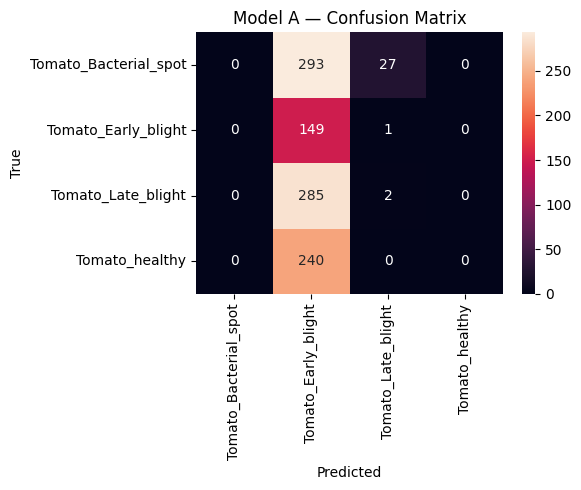

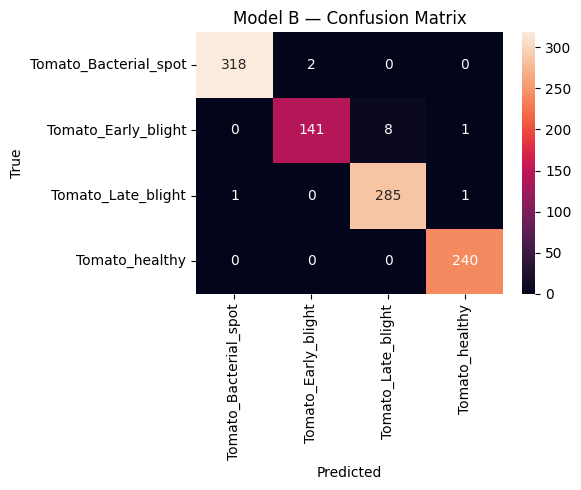

In [4]:
def plot_cm(cm, title):
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    plt.tight_layout(); plt.show()
    fig.savefig(os.path.join(FIG_DIR, f"{title.replace(' ','_').lower()}.png"), dpi=150)

plot_cm(cmA, "Model A — Confusion Matrix")
plot_cm(cmB, "Model B — Confusion Matrix")


In [5]:
def pick(report):
    return {
        "accuracy":            round(report["accuracy"], 4),
        "precision_macro":     round(report["macro avg"]["precision"], 4),
        "recall_macro":        round(report["macro avg"]["recall"], 4),
        "f1_macro":            round(report["macro avg"]["f1-score"], 4),
        "precision_weighted":  round(report["weighted avg"]["precision"], 4),
        "recall_weighted":     round(report["weighted avg"]["recall"], 4),
        "f1_weighted":         round(report["weighted avg"]["f1-score"], 4),
    }

summary_df = pd.DataFrame.from_dict({
    "Model A (Baseline CNN)": pick(reportA),
    "Model B (MobileNetV2 FT)": pick(reportB)
}, orient="index")

summary_path = os.path.join(MET_DIR, "comparison_table.csv")
summary_df.to_csv(summary_path)
summary_df


,accuracy,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted
Model A (Baseline CNN),0.1515,0.0552,0.2501,0.0699,0.0424,0.1515,0.0438
Model B (MobileNetV2 FT),0.9870,0.9868,0.9817,0.9841,0.9870,0.9870,0.9869


In [6]:
text = []
text.append("=== Part B — Comparison Summary ===")
text.append(f"Classes: {', '.join(class_names)}")
text.append("")
text.append("Model A (Baseline CNN)")
text.append(f"- Accuracy: {reportA['accuracy']:.3f}")
text.append(f"- Macro F1: {reportA['macro avg']['f1-score']:.3f}")
text.append("")
text.append("Model B (MobileNetV2 Fine-tuned)")
text.append(f"- Accuracy: {reportB['accuracy']:.3f}")
text.append(f"- Macro F1: {reportB['macro avg']['f1-score']:.3f}")
text.append("")
text.append("Key Observations:")
if reportB["accuracy"] > reportA["accuracy"]:
    text.append(f"- Model B outperforms Model A by {(reportB['accuracy']-reportA['accuracy'])*100:.1f} pp in accuracy.")
if reportB["macro avg"]["f1-score"] > reportA["macro avg"]["f1-score"]:
    text.append(f"- Model B has higher macro-F1 (+{(reportB['macro avg']['f1-score']-reportA['macro avg']['f1-score']):.3f}), indicating better performance across classes.")
text.append("- Most residual errors appear between visually similar diseases (e.g., early vs late blight).")
text.append("- Transfer learning with ImageNet features + fine-tuning generalizes far better than a small CNN trained from scratch.")

save_path = os.path.join(MET_DIR, "comparison_summary.txt")
with open(save_path, "w", encoding="utf-8") as f:
    f.write("\n".join(text))
print("Saved:", save_path)
print("\n".join(text))


Saved: C:\cv_partb\outputs\metrics\comparison_summary.txt
=== Part B — Comparison Summary ===
Classes: Tomato_Bacterial_spot, Tomato_Early_blight, Tomato_Late_blight, Tomato_healthy

Model A (Baseline CNN)
- Accuracy: 0.151
- Macro F1: 0.070

Model B (MobileNetV2 Fine-tuned)
- Accuracy: 0.987
- Macro F1: 0.984

Key Observations:
- Model B outperforms Model A by 83.6 pp in accuracy.
- Model B has higher macro-F1 (+0.914), indicating better performance across classes.
- Most residual errors appear between visually similar diseases (e.g., early vs late blight).
- Transfer learning with ImageNet features + fine-tuning generalizes far better than a small CNN trained from scratch.


In [7]:
IMG_SMALL = (160,160)
test_small = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR,"test"),
    image_size=IMG_SMALL, batch_size=BATCH_SIZE,
    label_mode="categorical", seed=SEED, shuffle=False
)
reportB_small, cmB_small = evaluate_model(pathB, test_small, class_names)
print("Model B @160 — accuracy:", reportB_small["accuracy"], "macro F1:", reportB_small["macro avg"]["f1-score"])


Found 997 files belonging to 4 classes.


ValueError: Input 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 160, 160, 3)